In [1]:
import numpy as np

np.random.seed(42)

In [2]:
from load_data import *

# 1. load and preprocess audio and label data
#X, Y_p, phoneme = load_processed_data(max_songs=5000)

# 2. get index for label data
label_to_ix = {p:i for i,p in enumerate(phoneme)}
ix_to_label = {i:p for i,p in enumerate(phoneme)}

100%|██████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 14743.14it/s]


In [3]:
from torch.utils.data import Dataset
import torch

class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, label_list):
        self.mfcc_list = mfcc_list   # List of tensors (seq_len, n_mfcc)
        self.label_list = label_list # List of tensors (seq_len)

    def __len__(self):
        return len(self.mfcc_list)

    def __getitem__(self, idx):
        return self.mfcc_list[idx], self.label_list[idx]


In [4]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    mfcc_seqs, label_seqs = zip(*batch)

    mfcc_padded = pad_sequence(mfcc_seqs, batch_first=True)     # (batch_size, max_seq_len, n_mfcc)
    label_padded = pad_sequence(label_seqs, batch_first=True)   # (batch_size, max_seq_len)

    lengths = torch.tensor([seq.shape[0] for seq in mfcc_seqs]) # Original lengths

    return mfcc_padded, label_padded, lengths


In [13]:
from torch.utils.data import DataLoader
from helper_functions import *

BATCH_SIZE = 8

mfcc_list = [torch.tensor(mfcc, dtype=torch.float32) for mfcc in X]
label_list = [torch.tensor([label_to_ix[alabel[0]] for alabel in labels], dtype=torch.long) for labels in Y_p]

X_train, y_train, X_test, y_test = get_xy_split_data(mfcc_list, label_list)

train_dataset = MFCCDataset(X_train[:480], y_train[:480])
val_dataset = MFCCDataset(X_test[:120], y_test[:120])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [14]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.functional import log_softmax
from torch import nn

class PackedMFCCLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # Pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        
        # Unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        logits = self.fc(output)
        return torch.log_softmax(logits, dim=-1)  # shape: (batch_size, max_seq_len, num_classes)


In [53]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, n_layers=2,
                bidirectional=True, dropout=0.5):
        super().__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)

        # input size for final layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # dropout
        self.dropout = nn.Dropout(dropout)

        # final layer (fullly connected)
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x, lengths):
        # pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)

        # unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        logits = self.fc(output)
        #return logits
        return torch.log_softmax(logits, dim=-1)

In [16]:
len(mfcc_list)

5000

In [17]:
len(label_list)

5000

In [18]:
len(train_dataset)

480

In [19]:
len(val_dataset)

120

In [20]:
len(train_dataloader)

60

In [21]:
len(val_dataloader)

15

In [22]:
from tqdm import tqdm  # progress bar (optional)
import torch.optim as optim
import torch.nn.functional as F

num_epochs = 10
#num_classes = model.fc.out_features  # or set manually
INPUT_DIM = 39
HIDDEN_DIM = 64
NUM_CLASSES = 41

# Define device at the top
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and send model to device
model = PackedMFCCLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
model.to(device)

# Loss function and optimizer
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0.0

    for mfcc_batch, label_batch, lengths in train_dataloader:
        # Move data to device (e.g. GPU)
        mfcc_batch = mfcc_batch.to(device)
        label_batch = label_batch.to(device)
        lengths = lengths.to(device)

        # Forward pass
        logits = model(mfcc_batch, lengths)  # shape: (batch_size, max_seq_len, num_classes)

        # Flatten predictions and labels for loss calculation
        logits_flat = logits.view(-1, NUM_CLASSES)
        labels_flat = label_batch.view(-1)

        # Loss and backprop
        loss = loss_fn(logits_flat, labels_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")


 10%|█████▊                                                    | 1/10 [00:45<06:48, 45.34s/it]

Epoch 1/10 — Loss: 3.2829


 20%|███████████▌                                              | 2/10 [01:33<06:14, 46.81s/it]

Epoch 2/10 — Loss: 3.0664


 30%|█████████████████▍                                        | 3/10 [02:21<05:33, 47.69s/it]

Epoch 3/10 — Loss: 2.7345


 40%|███████████████████████▏                                  | 4/10 [03:07<04:39, 46.67s/it]

Epoch 4/10 — Loss: 2.5197


 50%|█████████████████████████████                             | 5/10 [03:51<03:49, 45.95s/it]

Epoch 5/10 — Loss: 2.3322


 60%|██████████████████████████████████▊                       | 6/10 [04:36<03:02, 45.61s/it]

Epoch 6/10 — Loss: 2.1648


 70%|████████████████████████████████████████▌                 | 7/10 [05:21<02:15, 45.29s/it]

Epoch 7/10 — Loss: 2.0539


 80%|██████████████████████████████████████████████▍           | 8/10 [06:06<01:30, 45.15s/it]

Epoch 8/10 — Loss: 1.9726


 90%|████████████████████████████████████████████████████▏     | 9/10 [06:50<00:44, 44.98s/it]

Epoch 9/10 — Loss: 1.8815


100%|█████████████████████████████████████████████████████████| 10/10 [07:35<00:00, 45.52s/it]

Epoch 10/10 — Loss: 1.8429


In [23]:
from sklearn.metrics import f1_score
import torch
from torch.nn.functional import log_softmax
import jiwer  # pip install jiwer if not installed

def evaluate(model, dataloader, loss_fn, device, num_classes, idx_to_token=None):
    model.eval()
    total_loss = 0.0
    per_seq_acc = []
    per_seq_f1 = []
    per_seq_wer = []
    per_seq_ids = []

    with torch.no_grad():
        for mfcc_batch, label_batch, lengths in tqdm(dataloader):
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)

            logits = model(mfcc_batch, lengths)
            loss = loss_fn(logits.view(-1, num_classes), label_batch.view(-1))
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)  # (batch_size, seq_len)

            for i in range(len(lengths)):
                pred_seq = preds[i, :lengths[i]].cpu().tolist()
                label_seq = label_batch[i, :lengths[i]].cpu().tolist()

                # Frame Accuracy for this sequence
                correct = sum(p == l for p, l in zip(pred_seq, label_seq))
                acc = correct / lengths[i].item()
                per_seq_acc.append(acc)

                # F1 Score for this sequence
                try:
                    f1 = f1_score(label_seq, pred_seq, average="macro", zero_division=0)
                except ValueError:
                    f1 = 0.0  # In case of missing classes
                per_seq_f1.append(f1)

                # WER for this sequence (requires idx_to_token)
                if idx_to_token:
                    pred_str = flat_n_get_string([idx_to_token[p] for p in pred_seq])
                    label_str = flat_n_get_string([idx_to_token[l] for l in label_seq])
                    #pred_str = " ".join([idx_to_token[p] for p in pred_seq])
                    #label_str = " ".join([idx_to_token[l] for l in label_seq])
                    wer = jiwer.wer(label_str, pred_str)
                    per_seq_wer.append(wer)
                    # find Insertions, Deletions, Substitutions
                    editops = decode_levenshtein(pred_str, label_str)
                    per_seq_ids.append(editops)

    avg_loss = total_loss / len(dataloader)
    avg_frame_acc = sum(per_seq_acc) / len(per_seq_acc)
    avg_f1 = sum(per_seq_f1) / len(per_seq_f1)
    avg_wer = sum(per_seq_wer) / len(per_seq_wer) if per_seq_wer else None

    print(f"\n🔍 Evaluation Summary")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Average Frame Accuracy: {avg_frame_acc:.4f}")
    print(f"Average F1 Score (Macro): {avg_f1:.4f}")
    if avg_wer is not None:
        print(f"Average WER: {avg_wer:.4f}")
    else:
        print("WER skipped — provide idx_to_token to enable WER computation.")

    return {
        "loss": avg_loss,
        "frame_accuracy": avg_frame_acc,
        "f1_score": avg_f1,
        "wer": avg_wer,
        "frame_scores": per_seq_acc,
        "f1_scores": per_seq_f1,
        "wer_scores": per_seq_wer,
        "IDS": per_seq_ids
    }

metrics = evaluate(
    model, val_dataloader, loss_fn, device,
    num_classes=NUM_CLASSES,  # number of output classes
    idx_to_token=ix_to_label  # optional for WER
)


100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.43it/s]


🔍 Evaluation Summary
Loss: 1.7016
Average Frame Accuracy: 0.3828
Average F1 Score (Macro): 0.1646
Average WER: 0.4903


In [28]:
metrics["IDS"]

[[['equal', 'Y', 'Y'],
  ['substitute', 'DH', 'TH'],
  ['equal', 'AE', 'AE'],
  ['insert', 'D', 'D'],
  ['equal', 'OW', 'OW'],
  ['substitute', 'UW', 'D'],
  ['equal', 'K', 'K'],
  ['insert', 'AH', 'AH'],
  ['equal', 'N', 'N'],
  ['delete', 'AH', 'AH'],
  ['equal', 'IY', 'IY']],
 [['equal', 'S', 'S'],
  ['substitute', 'AE', 'TH'],
  ['delete', 'AE', 'AE'],
  ['equal', 'D', 'D'],
  ['substitute', 'CH', 'OW'],
  ['equal', 'UW', 'UW'],
  ['delete', 'CH', 'CH'],
  ['equal', 'K', 'K'],
  ['delete', 'M', 'M'],
  ['equal', 'R', 'R'],
  ['insert', 'AW', 'AW'],
  ['equal', '__SIL__', '__SIL__'],
  ['insert', 'N', 'N'],
  ['equal', 'AH', 'AH'],
  ['substitute', 'IY', 'N'],
  ['equal', 'ER', 'ER'],
  ['delete', 'G', 'G'],
  ['equal', 'EH', 'EH']],
 [['equal', 'S', 'S'],
  ['substitute', 'OW', 'CH'],
  ['equal', 'UW', 'UW'],
  ['substitute', 'CH', 'JH'],
  ['equal', 'K', 'K'],
  ['insert', 'N', 'N'],
  ['equal', 'AH', 'AH'],
  ['delete', 'N', 'N'],
  ['equal', 'IY', 'IY'],
  ['delete', 'G', 'G'],


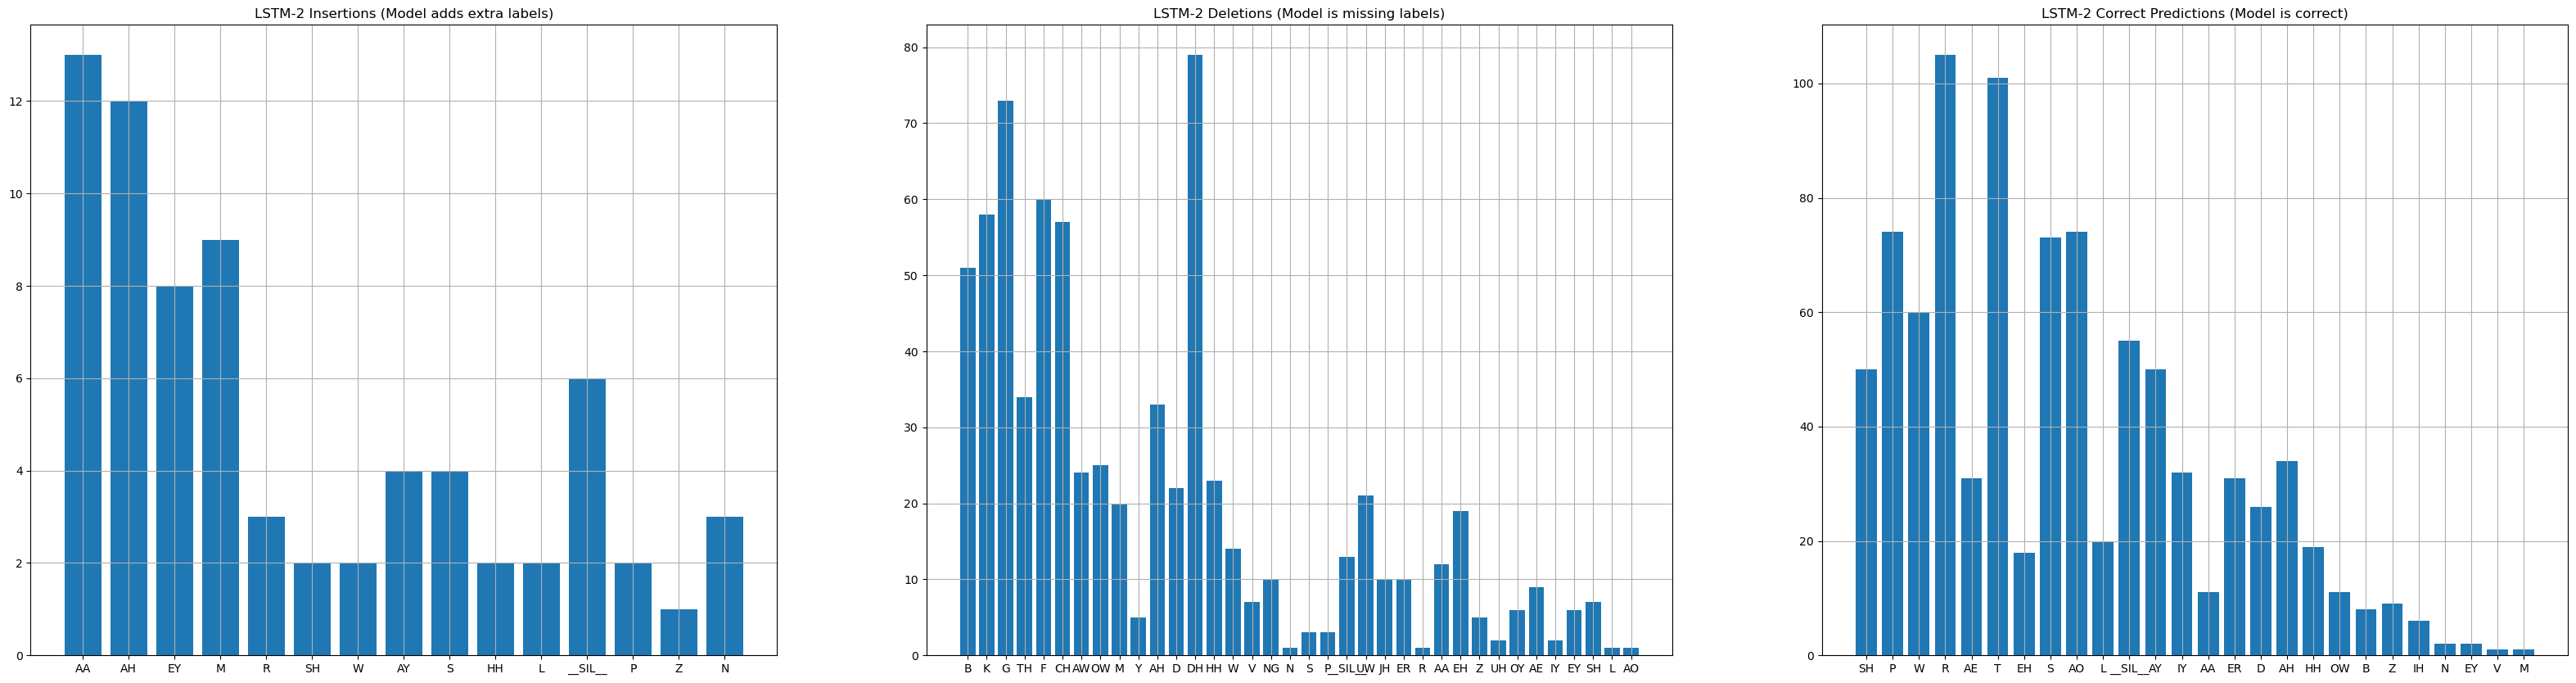

In [28]:
from analysis_per import *

ids_freqd_metrics = get_freqd_ids(metrics["IDS"])
visualise_IDE(ids_freqd_metrics, model_name="LSTM-2")

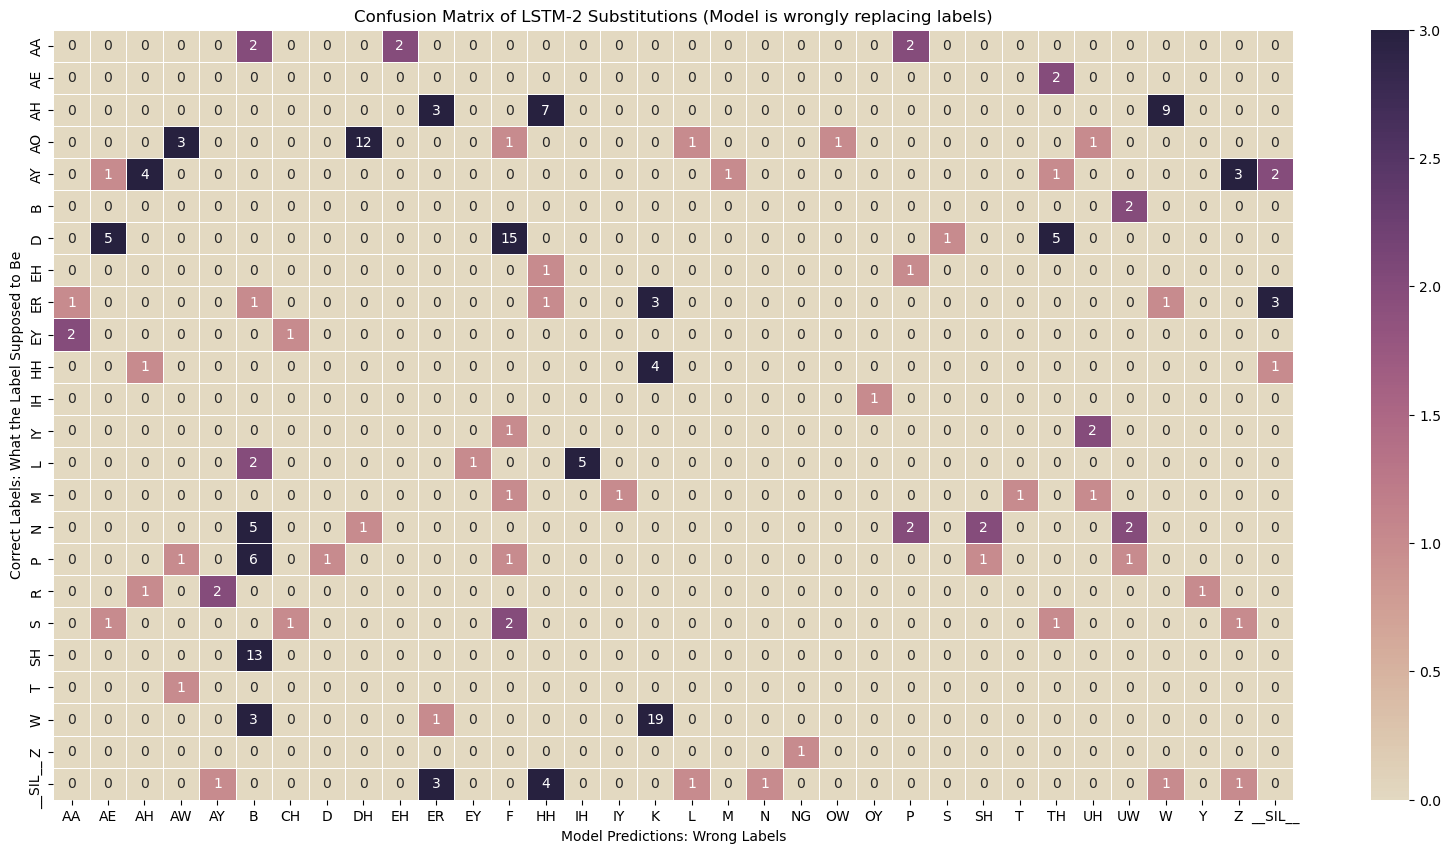

In [29]:
visualise_S(ids_freqd_metrics["Substitutions"], model_name="LSTM-2")

In [30]:
sum(ids_freqd_metrics["Insertions"].values())

73

In [31]:
len(ids_freqd_metrics["Insertions"].keys())

15

In [32]:
sum(ids_freqd_metrics["Deletions"].values())

727

In [33]:
len(ids_freqd_metrics["Deletions"].keys())

36

In [34]:
sum(ids_freqd_metrics["Substitutions"].values())

206

In [35]:
len(ids_freqd_metrics["Substitutions"].keys())

79

In [39]:
sum(ids_freqd_metrics["Equals"].values())

904

In [40]:
len(ids_freqd_metrics["Equals"].keys())

26

In [36]:
15+36+79

130

In [37]:
73+727+206

1006

In [48]:
ids_freqd_metrics["Equals"]["W"]

60

In [54]:
# Create model
model_biLSTM = BiLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)


def train(amodel, aloss_fn, lr=0.001):
    # send model to device
    amodel.to(device)
    aoptimizer = optim.Adam(amodel.parameters(), lr=lr)
    
    for epoch in tqdm(range(num_epochs)):
        amodel.train()
        total_loss = 0.0
    
        for mfcc_batch, label_batch, lengths in train_dataloader:
            # Move data to device (e.g. GPU)
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)
    
            # Forward pass
            logits = amodel(mfcc_batch, lengths)  # shape: (batch_size, max_seq_len, num_classes)
    
            # Flatten predictions and labels for loss calculation
            logits_flat = logits.view(-1, NUM_CLASSES)
            labels_flat = label_batch.view(-1)
    
            # Loss and backprop
            loss = aloss_fn(logits_flat, labels_flat)
            aoptimizer.zero_grad()
            loss.backward()
            aoptimizer.step()
    
            total_loss += loss.item()
    
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")

        
train(model_biLSTM, nn.CrossEntropyLoss())


 10%|█████▉                                                     | 1/10 [03:09<28:26, 189.65s/it]

Epoch 1/10 — Loss: 3.4004


 20%|███████████▊                                               | 2/10 [06:19<25:18, 189.77s/it]

Epoch 2/10 — Loss: 3.2758


 30%|█████████████████▋                                         | 3/10 [09:25<21:56, 188.11s/it]

Epoch 3/10 — Loss: 2.9887


 40%|███████████████████████▌                                   | 4/10 [12:44<19:14, 192.36s/it]

Epoch 4/10 — Loss: 2.8250


 50%|█████████████████████████████▌                             | 5/10 [15:54<15:57, 191.58s/it]

Epoch 5/10 — Loss: 2.6516


 60%|███████████████████████████████████▍                       | 6/10 [18:38<12:08, 182.22s/it]

Epoch 6/10 — Loss: 2.5108


 70%|█████████████████████████████████████████▎                 | 7/10 [22:58<10:22, 207.44s/it]

Epoch 7/10 — Loss: 2.4165


 80%|███████████████████████████████████████████████▏           | 8/10 [26:19<06:51, 205.53s/it]

Epoch 8/10 — Loss: 2.3071


 90%|█████████████████████████████████████████████████████      | 9/10 [29:44<03:25, 205.30s/it]

Epoch 9/10 — Loss: 2.1952


100%|██████████████████████████████████████████████████████████| 10/10 [33:12<00:00, 199.26s/it]

Epoch 10/10 — Loss: 2.1103


In [55]:
bi_metrics = evaluate(
    model_biLSTM, val_dataloader, nn.CrossEntropyLoss(), device,
    num_classes=NUM_CLASSES,  # number of output classes
    idx_to_token=ix_to_label  # optional for WER
)

100%|███████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.28it/s]


🔍 Evaluation Summary
Loss: 2.2249
Average Frame Accuracy: 0.4162
Average F1 Score (Macro): 0.2230
Average WER: 0.3367


In [68]:
import torch
from torchinfo import summary

summary(model_biLSTM)

Layer (type:depth-idx)                   Param #
BiLSTM                                   --
├─LSTM: 1-1                              153,088
├─Dropout: 1-2                           --
├─Linear: 1-3                            5,289
Total params: 158,377
Trainable params: 158,377
Non-trainable params: 0

In [69]:
summary(model)

Layer (type:depth-idx)                   Param #
PackedMFCCLSTM                           --
├─LSTM: 1-1                              26,880
├─Linear: 1-2                            2,665
Total params: 29,545
Trainable params: 29,545
Non-trainable params: 0